In [1]:
import pandas as pd
import numpy as np
import pickle, os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('/home/work/toy-project/data/df_preprocessesd.pkl')

In [3]:
df.loan_status.value_counts()

0    1087175
1     295176
Name: loan_status, dtype: int64

In [3]:
df.fillna(-1,inplace = True)
df.drop(["initial_list_status","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv"
         ,"total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries",
         "collection_recovery_fee","last_pymnt_amnt",
         "last_fico_range_high","last_fico_range_low"],1,inplace=True)

In [5]:
df.shape

(1382351, 91)

## 1. ANOVA

ANOVA Feature Selection - Continuous Variable(top 50 sorted by F-value)

In [6]:
obj_col = ['application_type', 'debt_settlement_flag', 'disbursement_method',
           'hardship_flag', 'home_ownership',
        'purpose', 'pymnt_plan', 'sub_grade', 'term',
       'verification_status','grade']

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
num_col = np.setdiff1d(df.select_dtypes('number').columns.values, obj_col+['id','loan_status'])
X, y = df[num_col], df['loan_status']

selector = SelectKBest(f_classif, k=50)
selector.fit(X,y)
cols = selector.get_support(indices = True)
df_anova = df.iloc[:,cols]
print(df_anova.shape)

(1382351, 50)


In [9]:
cols = X.columns.values[selector.get_support()]
scores = np.round(selector.scores_[selector.get_support()]*0.1, 2)
cols_scores = list(zip(cols, scores))

ns_df = pd.DataFrame(data = cols_scores, columns=['Feat_names', 'F_Scores'])
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)  

                Feat_names  F_Scores
17                int_rate  10087.16
9           fico_range_low   2312.87
8          fico_range_high   2312.82
0     acc_open_past_24mths   1439.14
1                 all_util   1302.54
40             open_rv_24m   1278.71
33      num_tl_op_past_12m   1088.84
39             open_rv_12m   1080.37
35             open_acc_6m   1045.84
14            inq_last_12m    984.79
6                      dti    973.70
37             open_il_12m    875.93
12                 il_util    865.77
38             open_il_24m    820.49
13                  inq_fi    810.56
28         num_actv_rev_tl    758.80
4           bc_open_to_buy    734.70
30     num_rev_tl_bal_gt_0    727.17
10             funded_amnt    709.11
18               loan_amnt    707.79
11         funded_amnt_inv    701.41
3              avg_cur_bal    668.44
23                mort_acc    656.51
45         tot_hi_cred_lim    628.24
41        percent_bc_gt_75    551.32
47          total_bc_limit    543.70
5

## 2. Chi-Squared Test

Chi-Squared Test Feature Selection - Categorical Variable(sorted by P-value)

In [7]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

X, y = df[obj_col], df['loan_status']

# df_new = SelectKBest(f_classif, k=50).fit_transform(X, y)
selector = SelectKBest(chi2, k='all')
selector.fit(X,y)
cols = selector.get_support(indices = True)
df_chi = df.iloc[:,cols]
print(df_chi.shape)

(1382351, 11)


In [10]:
cols = X.columns.values[selector.get_support()]
scores = selector.pvalues_[selector.get_support()]
cols_scores = list(zip(cols, scores))
ns_df = pd.DataFrame(data = cols_scores, columns=['Feat_names', 'P_Values'])
ns_df_sorted = ns_df.sort_values(['P_Values', 'Feat_names'], ascending = [True, True])
print(ns_df_sorted) 

              Feat_names      P_Values
0       application_type  0.000000e+00
1   debt_settlement_flag  0.000000e+00
10                 grade  0.000000e+00
3          hardship_flag  0.000000e+00
4         home_ownership  0.000000e+00
5                purpose  0.000000e+00
6             pymnt_plan  0.000000e+00
7              sub_grade  0.000000e+00
8                   term  0.000000e+00
9    verification_status  0.000000e+00
2    disbursement_method  4.828748e-27


## 3. ML Model_LGBM

In [4]:
import time
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score , average_precision_score 
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve ,auc , log_loss ,  classification_report 
from sklearn.model_selection import StratifiedKFold , KFold, GroupKFold, cross_val_score
from sklearn import metrics

import gc, warnings
warnings.filterwarnings('ignore')

In [5]:
remove_features = ['id', 'loan_status','earliest_cr_line', 'issue_d', 'last_credit_pull_d', 'last_pymnt_d', 'next_pymnt_d','Unnamed: 0']

In [6]:
SEED = 2021
TARGET = 'loan_status'

In [7]:
features_columns = [col for col in list(df) if col not in remove_features]
X,y = df[features_columns], df[TARGET]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

# predict the results
y_pred=clf.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('LightGBM Model AUC score: {0:0.4f}'.format(roc_auc_score(y_test, y_pred)))
print('LightGBM Model Precision: {0:0.4f}'.format(precision_score(y_test, y_pred)))
print('LightGBM Model Recall: {0:0.4f}'.format(recall_score(y_test, y_pred)))

LightGBM Model AUC score: 0.5901
LightGBM Model Precision: 0.7774
LightGBM Model Recall: 0.1954


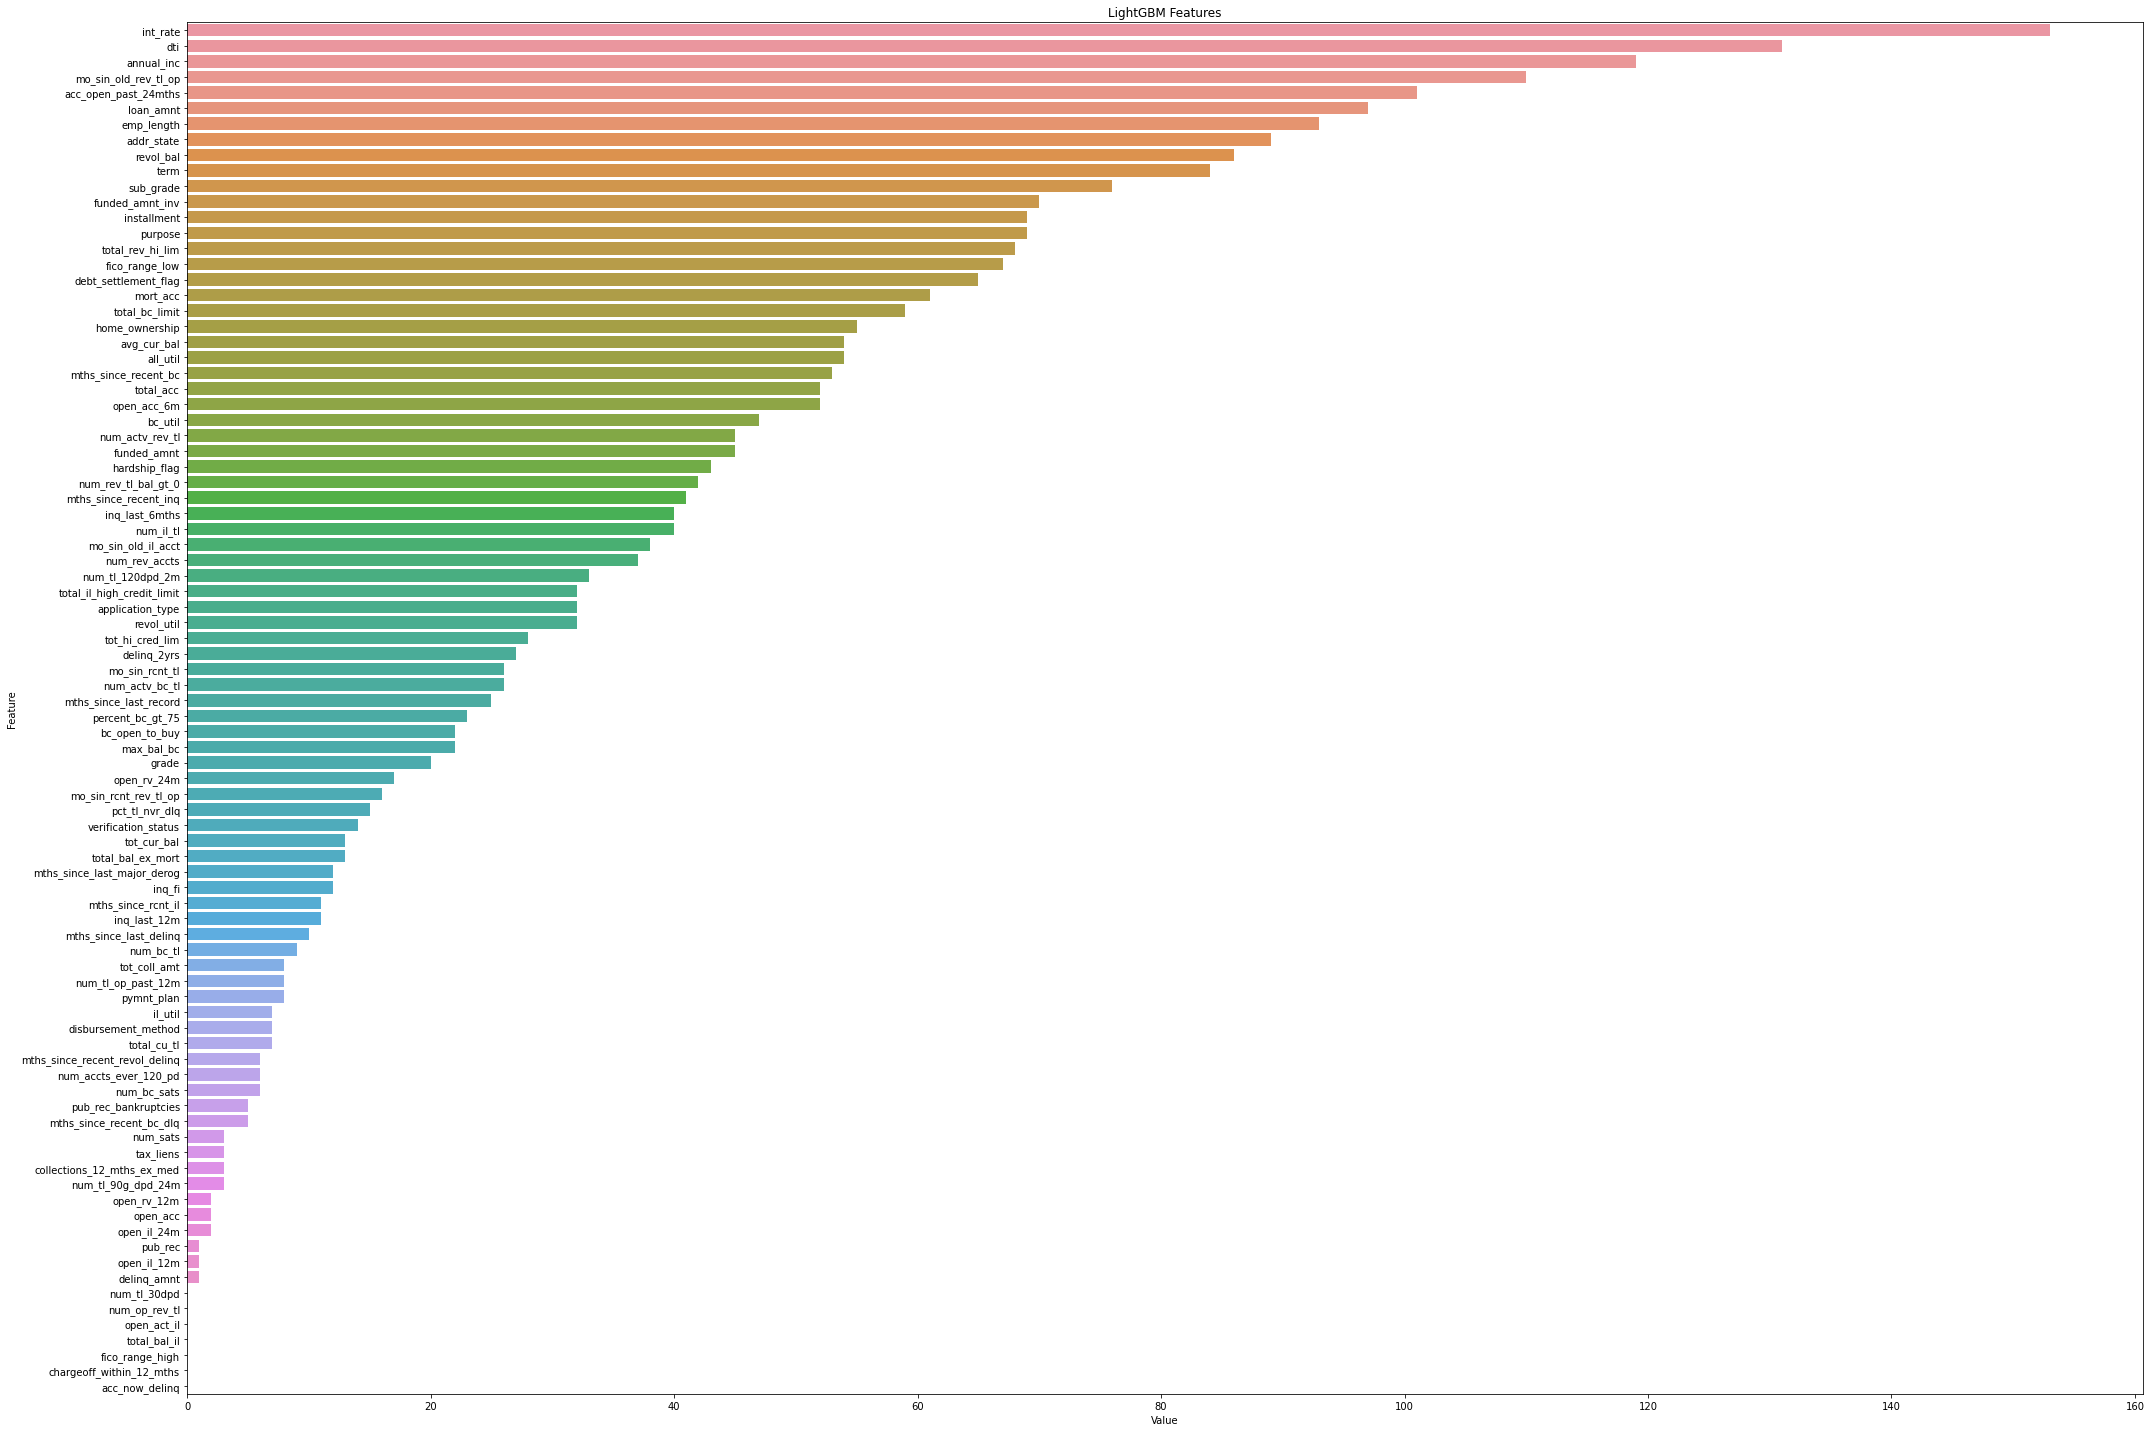

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_imp = pd.DataFrame(sorted(zip(X.columns,clf.feature_importances_)), columns=['Feature','Value'])

plt.figure(figsize=(30, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [10]:
lgb_imp = feature_imp.sort_values(by="Value", ascending=False).head(60).Feature.tolist()
lgb_imp += ['loan_status','issue_d','id']

In [11]:
lgb_imp

['int_rate',
 'dti',
 'annual_inc',
 'mo_sin_old_rev_tl_op',
 'acc_open_past_24mths',
 'loan_amnt',
 'emp_length',
 'addr_state',
 'revol_bal',
 'term',
 'sub_grade',
 'funded_amnt_inv',
 'installment',
 'purpose',
 'total_rev_hi_lim',
 'fico_range_low',
 'debt_settlement_flag',
 'mort_acc',
 'total_bc_limit',
 'home_ownership',
 'avg_cur_bal',
 'all_util',
 'mths_since_recent_bc',
 'total_acc',
 'open_acc_6m',
 'bc_util',
 'num_actv_rev_tl',
 'funded_amnt',
 'hardship_flag',
 'num_rev_tl_bal_gt_0',
 'mths_since_recent_inq',
 'inq_last_6mths',
 'num_il_tl',
 'mo_sin_old_il_acct',
 'num_rev_accts',
 'num_tl_120dpd_2m',
 'total_il_high_credit_limit',
 'application_type',
 'revol_util',
 'tot_hi_cred_lim',
 'delinq_2yrs',
 'mo_sin_rcnt_tl',
 'num_actv_bc_tl',
 'mths_since_last_record',
 'percent_bc_gt_75',
 'bc_open_to_buy',
 'max_bal_bc',
 'grade',
 'open_rv_24m',
 'mo_sin_rcnt_rev_tl_op',
 'pct_tl_nvr_dlq',
 'verification_status',
 'tot_cur_bal',
 'total_bal_ex_mort',
 'mths_since_last_

In [25]:
df[lgb_imp].to_pickle('/home/work/toy-project/data/lgb_selected.pkl')

### 3-(1) SHAP

In [19]:
df_sample = X_train.copy()
df_sample.sample(frac=0.1, replace=True, random_state=2020)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
19274,16000.0,16000.0,16000.0,0,13.18,540.50,2,12,3,1,...,80.0,0.0,0.0,248497.0,99941.0,39200.0,66922.0,0,0,0
1945387,9000.0,9000.0,9000.0,0,13.49,305.38,2,11,0,5,...,25.0,0.0,0.0,97554.0,65138.0,11300.0,81654.0,0,0,0
1260279,3800.0,3800.0,3800.0,0,19.52,140.30,4,21,9,5,...,100.0,0.0,0.0,9200.0,8542.0,6300.0,0.0,0,0,0
1825134,12000.0,12000.0,11975.0,0,11.55,396.00,1,7,1,1,...,40.0,0.0,0.0,348229.0,38417.0,12000.0,31584.0,0,0,0
1905156,10400.0,10400.0,10400.0,0,17.77,374.79,3,15,2,5,...,50.0,0.0,0.0,38438.0,23663.0,14400.0,19846.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218744,15000.0,15000.0,15000.0,0,11.44,494.22,1,8,11,1,...,50.0,1.0,1.0,144237.0,10630.0,7000.0,5757.0,0,0,0
1832518,30225.0,30225.0,30225.0,0,14.33,1037.87,2,10,1,1,...,7.7,0.0,0.0,747210.0,40623.0,79980.0,20000.0,0,0,0
1907216,31200.0,31200.0,31200.0,0,18.75,1139.73,3,17,1,1,...,50.0,0.0,0.0,344000.0,80041.0,31000.0,71043.0,0,0,0
1796432,9750.0,9750.0,9750.0,0,18.55,355.19,3,16,4,5,...,100.0,0.0,0.0,51439.0,26055.0,2000.0,36839.0,0,0,0


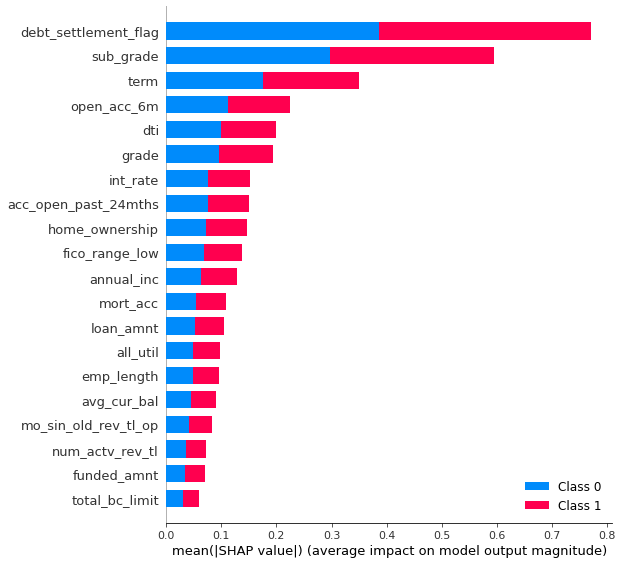

In [20]:
import shap
shap_values = shap.TreeExplainer(clf).shap_values(df_sample)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [21]:
feature_names = X_train.columns.values
feature_importance = pd.DataFrame(list(zip(feature_names, shap_values[0].sum(0))), columns=['feature_name', 'feature_importance_vals'])
feature_importance = feature_importance.iloc[(-np.abs(feature_importance['feature_importance_vals'].values)).argsort()]
feat_imp = feature_importance['feature_name'].head(60).values.tolist()